In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn

In [2]:
import functools as ft
import pandas as pd
import numpy as np
import matplotlib as mp
import seaborn as sb
import warnings
warnings.filterwarnings('ignore')

In [3]:
def savefig(fig, path):
    fig.savefig(path, bbox_inches='tight')

In [4]:
def perf(row):
    return 1 - row.result if row.result in [row.auc, row.acc]\
           else row.result
    
def norm_perf(row):
    return 1 - row.result if row.result in [row.auc, row.acc]\
           else row.result / (1+row.result)

In [5]:
results_dir = "./stable"
import os
print("current working dir: %s", os.getcwd())
try:
    os.chdir(results_dir)
except:
    pass
os.getcwd()

current working dir: %s /Users/seb/repos/ml/automlbenchmark


'/Users/seb/repos/ml/automlbenchmark/stable'

In [6]:
all_results = pd.read_csv('results.csv')\
                .replace('constantpredictor_enc', 'constantpredictor')
all_results.task = all_results.task.str.lower()
all_results.framework = all_results.framework.str.lower()
all_results['perf'] = [perf(row) for _, row in all_results.iterrows()]
all_results['norm_perf'] = [norm_perf(row) for _, row in all_results.iterrows()]

all_frameworks = all_results.framework.unique()
all_tasks = all_results.task.unique()
all_folds = all_results.fold.unique()
sorted_ints = lambda arr: sorted(list(map(int, arr[~np.isnan(arr)])))

In [7]:
done = all_results.groupby(['task', 'framework'])['fold'].unique()
done

task               framework        
adult              autosklearn          [0, 1, 2, 3, 4, 6, 5, 7, 8, 9]
                   constantpredictor    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                   h2oautoml            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                   randomforest         [0, 3, 2, 5, 4, 1, 6, 7, 8, 9]
                   tpot                 [0, 1, 3, 2, 5, 4, 6, 7, 8, 9]
australian         autosklearn          [0, 4, 2, 6, 1, 3, 5, 8, 7, 9]
                   constantpredictor    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                   h2oautoml            [4, 0, 1, 2, 5, 3, 7, 9, 6, 8]
                   oboe                          [0, 1, 3, 9, 5, 7, 8]
                   randomforest         [0, 1, 5, 2, 3, 7, 4, 6, 8, 9]
                   tpot                 [0, 1, 3, 4, 2, 5, 6, 8, 7, 9]
bioresponse        autosklearn          [1, 0, 3, 4, 2, 5, 6, 7, 8, 9]
                   constantpredictor    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                   h2oautoml            

In [8]:
nfolds = 10
not_done = pd.DataFrame([(task, framework) for task in all_tasks 
                                           for framework in all_frameworks 
                                           if (task, framework) not in done.index],
                        columns=['task', 'framework'])
missing = all_results.append(not_done).groupby(['task', 'framework'])['fold']\
                     .unique()\
                     .map(sorted_ints)\
                     .map(lambda arr: sorted(list(set(range(0, nfolds)) - set(arr))))\
                     .where(lambda values: values.map(lambda arr: len(arr) > 0))\
                     .dropna()
missing

task               framework        
adult              oboe                 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
australian         oboe                                      [2, 4, 6]
blood-transfusion  oboe                 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                   randomforest                                    [6]
christine          autosklearn                                     [6]
                   tpot                                      [2, 4, 5]
cnae-9             autosklearn                                     [9]
                   tpot                 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
connect-4          oboe                 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                   tpot                                            [6]
dilbert            autosklearn                                  [5, 8]
                   h2oautoml                                       [9]
dresses-sales      autosklearn                                     [5]
                   oboe                 

In [9]:
failed = all_results.where(np.isnan(all_results.result))\
                    .groupby(['task', 'framework'])['fold']\
                    .unique()\
                    .map(sorted_ints)
failed

task        framework   
adult       h2oautoml                                  [9]
australian  autosklearn                                [7]
christine   tpot                     [0, 1, 3, 6, 7, 8, 9]
credit-g    oboe                                 [1, 2, 9]
dilbert     tpot            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
fabert      autosklearn                                [0]
            oboe            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
            tpot            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
helena      randomforest                            [6, 8]
kc1         autosklearn     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
            randomforest       [0, 1, 3, 4, 5, 6, 7, 8, 9]
vehicle     autosklearn                                [6]
            oboe                                    [3, 5]
Name: fold, dtype: object

In [10]:
done.iloc[done.index.get_level_values('framework').isin(['autosklearn', 'h2oautoml', 'tpot'])]\
    .apply(sorted_ints)

task               framework  
adult              autosklearn    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                   h2oautoml      [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                   tpot           [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
australian         autosklearn    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                   h2oautoml      [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                   tpot           [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
bioresponse        autosklearn    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                   h2oautoml      [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                   tpot           [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
blood-transfusion  autosklearn    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                   h2oautoml      [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                   tpot           [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
car                autosklearn    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                   h2oautoml      [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                   tpot           [0, 1, 2, 3, 4, 5, 6, 7, 

In [11]:
res = all_results.groupby(['task', 'framework'])
mean_res_df = res['result'].mean().unstack()
mean_perf_df = res['perf'].mean().unstack()
mean_norm_perf_df = res['norm_perf'].mean().unstack()

In [12]:
mean_res_df.to_csv("result_summary.csv", float_format='%.6g')
mean_perf_df.to_csv("perf_summary.csv", float_format='%.6g')
mean_norm_perf_df.to_csv("norm_perf_summary.csv", float_format='%.6g')

In [13]:
def draw_heatmap(df):
    sb.set(style="whitegrid")
    hm = sb.heatmap(df, yticklabels=df.index, annot=True, cmap='YlOrBr')
    hm.figure.set_size_inches(8, 8)
    hm.figure.set_dpi(120)
    return hm.figure

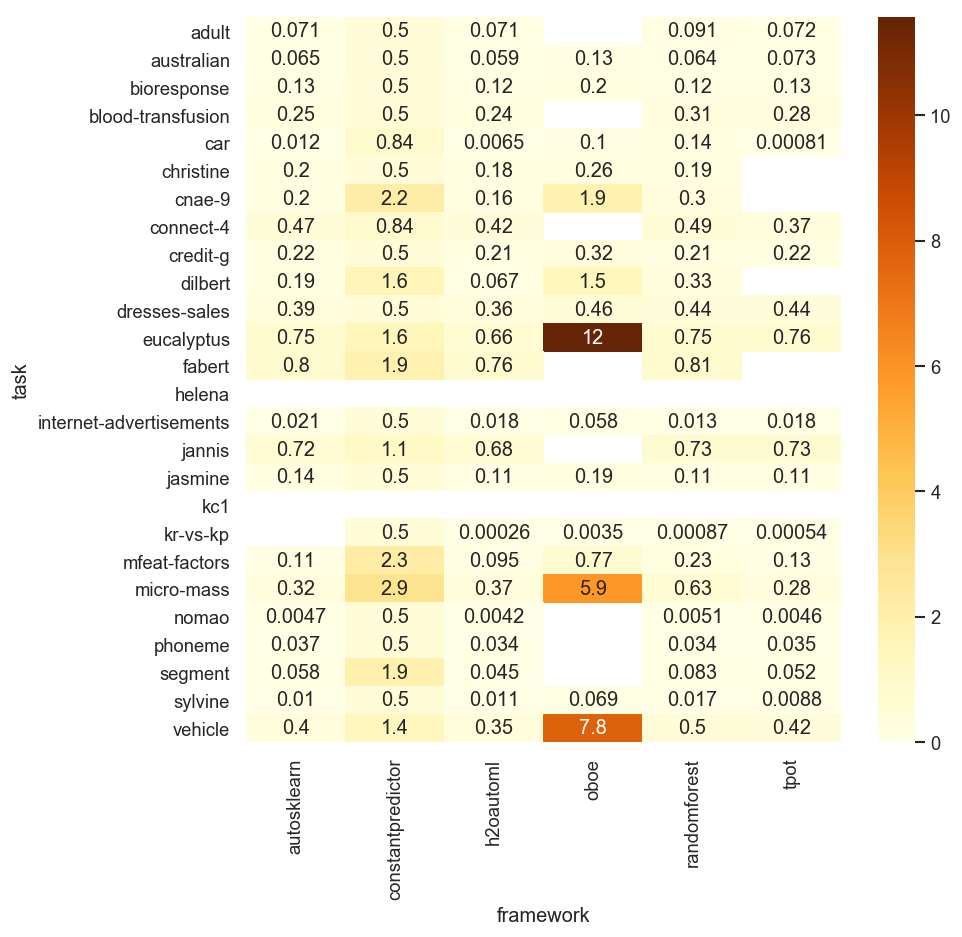

In [14]:
heat_perf_fig = draw_heatmap(mean_perf_df)

In [15]:
savefig(heat_perf_fig, "heat_perf.png")

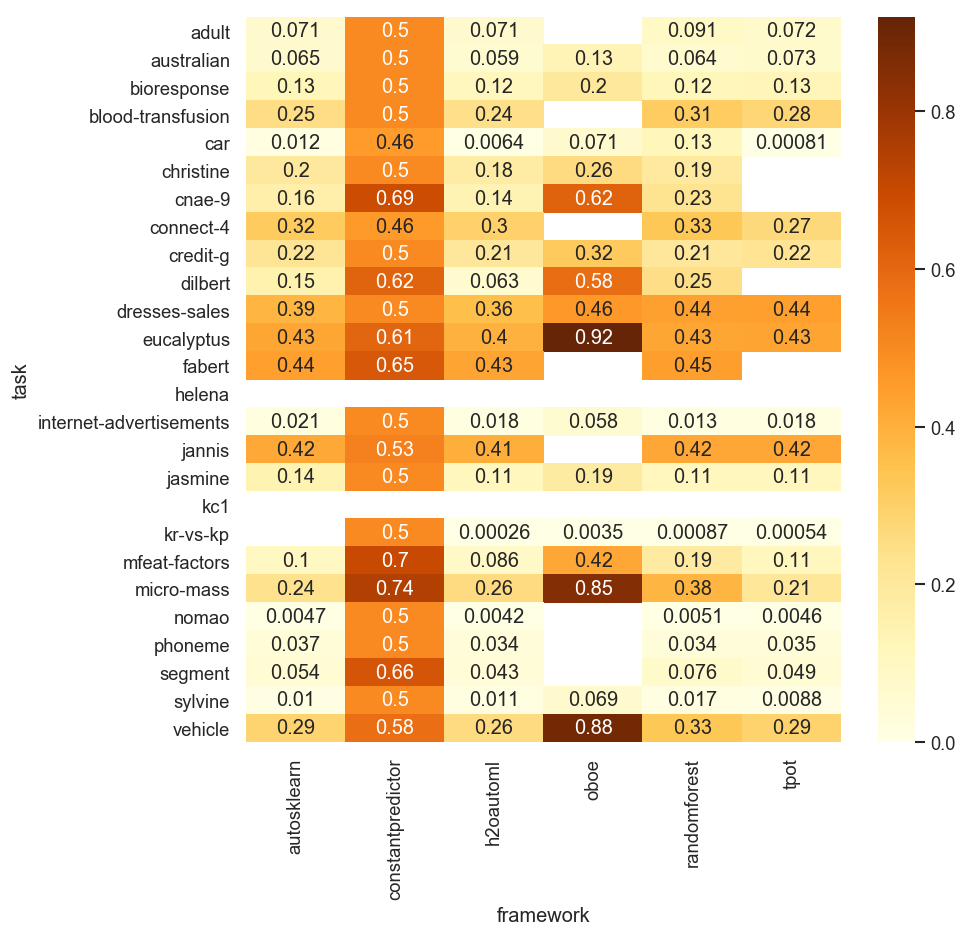

In [16]:
heat_norm_perf_fig = draw_heatmap(mean_norm_perf_df)

In [17]:
savefig(heat_norm_perf_fig, "heat_norm_perf.png")

In [18]:
def draw_parallel_coord(df, class_column, yscale='linear'):
    parallel_fig = mp.pyplot.figure(dpi=120, figsize=(10, 8))
    mp.pyplot.xticks(rotation=90)
    mp.pyplot.yscale(yscale)
    axes = pd.plotting.parallel_coordinates(df, class_column=class_column, colormap='tab10')
#     axes.set_yscale('log')
#     axes.tick_params(axis='x', labelrotation=90) 
    return parallel_fig

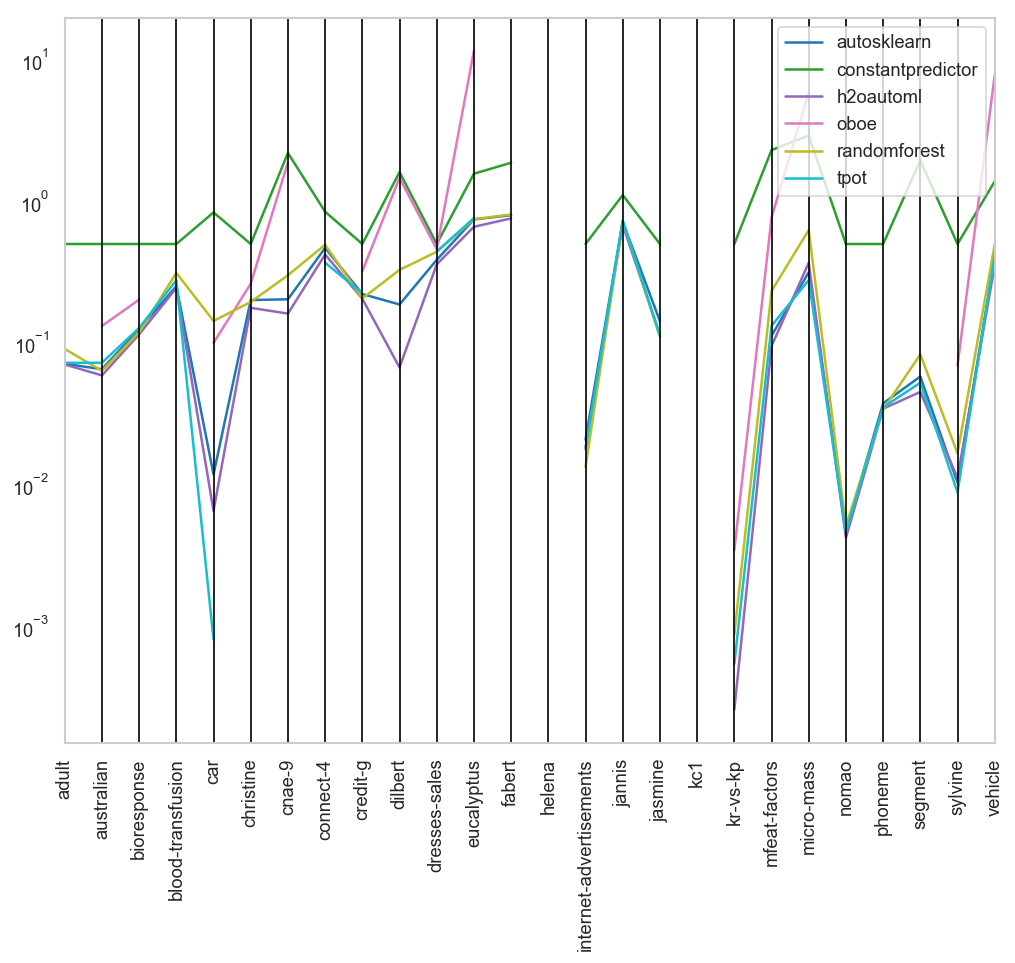

In [19]:
mean_perf_parallel_df = res['perf'].mean().unstack(level=0)
mean_perf_parallel_df.reset_index(inplace=True)
parallel_perf_log_fig = draw_parallel_coord(mean_perf_parallel_df, 'framework', yscale='log')

In [20]:
savefig(parallel_perf_log_fig, "parallel_coordinates_perf_log.png")

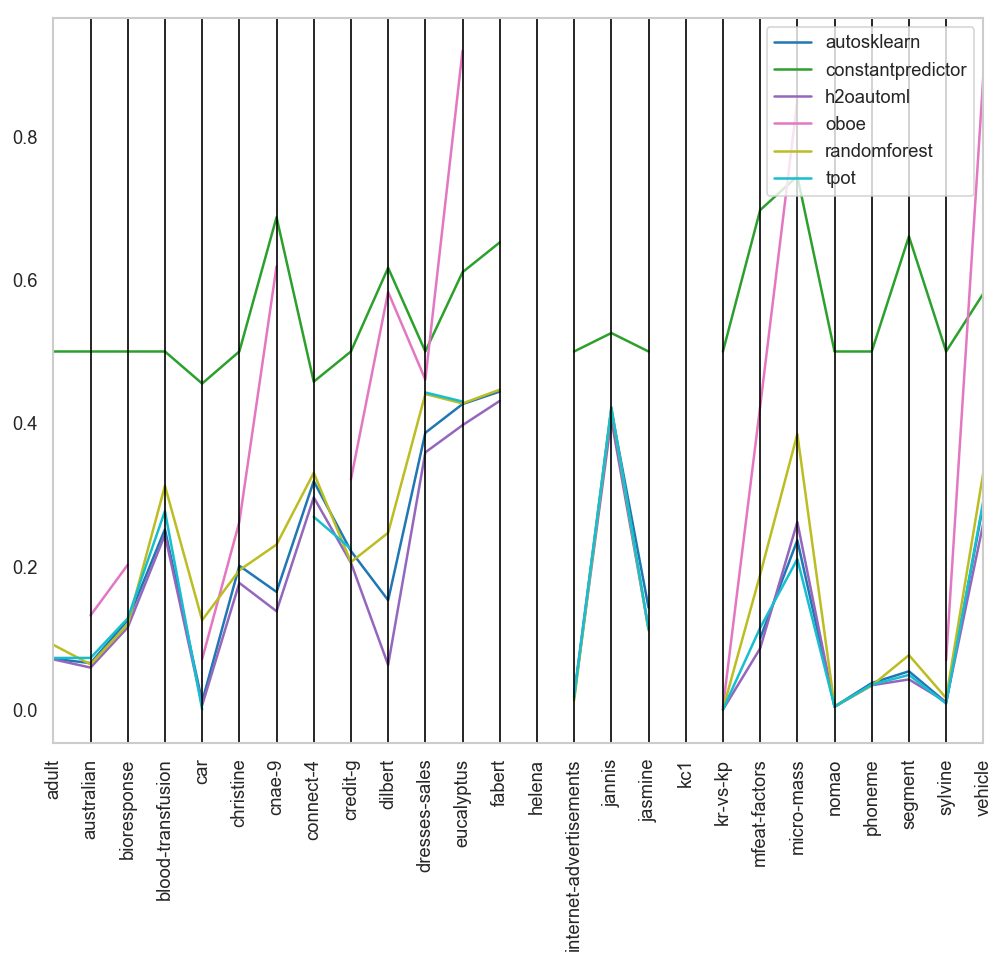

In [21]:
mean_norm_perf_parallel_df = res['norm_perf'].mean().unstack(level=0)
mean_norm_perf_parallel_df.reset_index(inplace=True)
parallel_norm_perf_fig = draw_parallel_coord(mean_norm_perf_parallel_df, 'framework')

In [22]:
def draw_stripplot(df, x, y, hue, xscale='linear', legend_loc='best'):
    sb.set(style="whitegrid")

    # Initialize the figure
    strip_fig, axes = mp.pyplot.subplots(dpi=120, figsize=(8, 8))
    axes.set_xscale(xscale)
    sb.despine(bottom=True, left=True)

    # Show each observation with a scatterplot
    sb.stripplot(x=x, y=y, hue=hue,
                 data=df, dodge=True, jitter=True,
                 alpha=.25, zorder=1)

    # Show the conditional means
    sb.pointplot(x=x, y=y, hue=hue,
                 data=df, dodge=.532, join=False, palette="tab10",
                 markers="d", scale=.75, ci=None)

    # Improve the legend 
    handles, labels = axes.get_legend_handles_labels()
    dist = int(len(labels)/2)
    axes.legend(handles[dist:], labels[dist:], title=hue,
                handletextpad=0, columnspacing=1,
                loc=legend_loc, ncol=1, frameon=True)
    return strip_fig

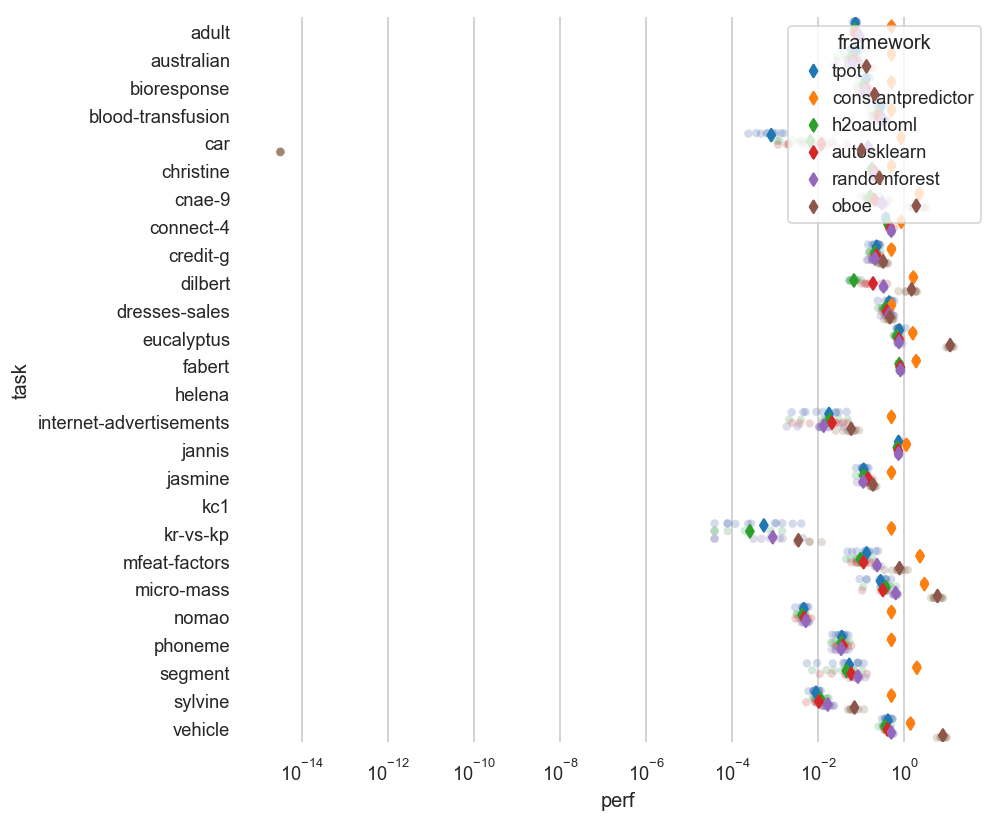

In [23]:
strip_perf_log_fig = draw_stripplot(
    all_results.sort_values(by='task'),
    x='perf',
    y='task',
    hue='framework',
    xscale='log',
    legend_loc='upper right'
)

In [24]:
savefig(strip_perf_log_fig, "stripplot_perf_log.png")

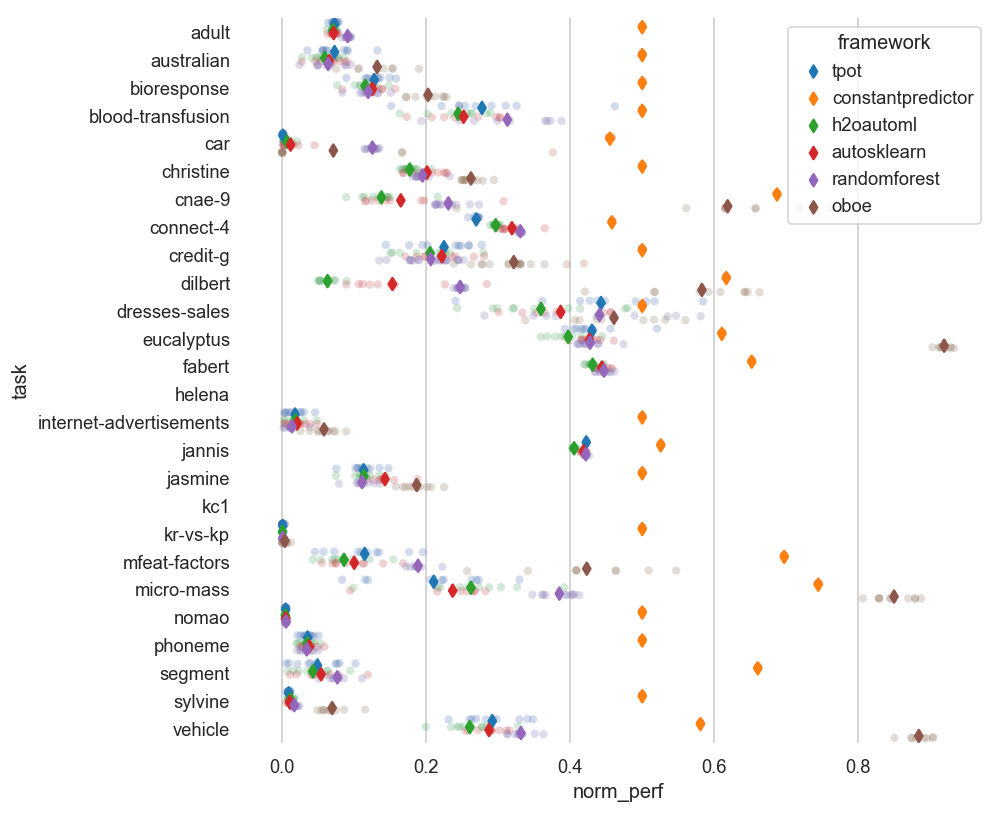

In [25]:
strip_norm_perf_fig = draw_stripplot(
    all_results.sort_values(by='task'),
    x='norm_perf',
    y='task',
    hue='framework',
    legend_loc='upper right'
)

In [26]:
savefig(strip_norm_perf_fig, "stripplot_norm_perf.png")

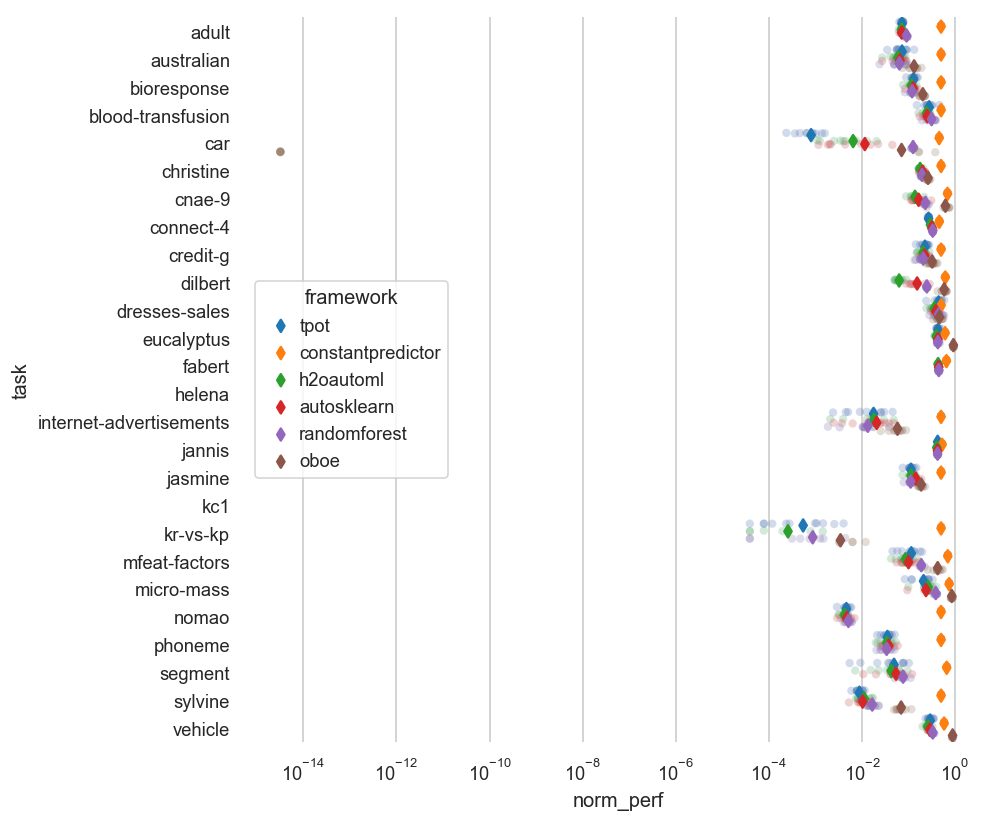

In [27]:
strip_norm_perf_log_fig = draw_stripplot(
    all_results.sort_values(by='task'),
    x='norm_perf',
    y='task',
    hue='framework',
    xscale='log',
    legend_loc='center left'
)

In [28]:
savefig(strip_norm_perf_log_fig, "stripplot_norm_perf_log.png")

In [29]:
def rank(perfs):
    sorted_perfs = np.sort(perfs.unique())
    ranks = pd.Series(index=perfs.index)
    for idx, value in perfs.items():
        try:
            ranks.at[idx] = np.where(sorted_perfs == value)[0][0] + 1
        except IndexError:
            ranks.at[idx] = np.nan
    return ranks

In [30]:
task_leaderboard_df = mean_perf_df.apply(rank, axis=1, result_type='broadcast').astype(object)
task_leaderboard_df.astype(float).to_csv('tasks_leaderboard.csv', float_format='%.f')
task_leaderboard_df

framework,autosklearn,constantpredictor,h2oautoml,oboe,randomforest,tpot
task,,,,,,
adult,2,5,1,NaN,4,3
australian,3,6,1,5,2,4
bioresponse,3,6,1,5,2,4
blood-transfusion,2,5,1,NaN,4,3
car,3,6,2,4,5,1
christine,3,5,1,4,2,NaN
cnae-9,2,5,1,4,3,NaN
connect-4,3,5,2,NaN,4,1
credit-g,3,6,1,5,2,4


In [31]:
folds_perf_df = all_results.pivot_table(index=['task', 'fold'], columns='framework', values='perf')
folds_leaderboard_df = folds_perf_df.apply(rank, axis=1, result_type='broadcast').astype(object)
folds_leaderboard_df.astype(float).to_csv('folds_leaderboard.csv', float_format='%.f')
folds_leaderboard_df

framework        autosklearn constantpredictor h2oautoml oboe randomforest  \
task        fold                                                             
adult       0              1                 5         2  NaN            4   
            1              2                 5         1  NaN            4   
            2              2                 5         1  NaN            4   
            3              3                 5         1  NaN            4   
            4              2                 5         1  NaN            4   
            5              2                 5         1  NaN            4   
            6              2                 5         1  NaN            4   
            7              1                 5         2  NaN            4   
            8              2                 5         1  NaN            4   
            9              2                 4       NaN  NaN            3   
australian  0              1                 6         3    5            2   
            1              1                 5         2    4            3   
            2              2                 5         1  NaN            4   
            3              4                 6         2    5            3   
            4              3                 5         1  NaN            2   
            5              2                 5         2    4            1   
            6              3                 5         1  NaN            2   
            7            NaN                 5         1    4            3   
            8              4                 6         1    5            2   
            9              2                 6         3    5            1   
bioresponse 0              1                 6         3    5            2   
            1              4                 6         1    5            2   
            2              4                 6         1    5            2   
            3              3                 6         1    5            2   
            4              4                 6         1    5            2   
            5              4                 6         1    5            2   
            6              3                 6         1    5            2   
            7              4                 6         1    5            2   
            8              3                 6         1    5            2   
            9              3                 6         1    5            2   
...                      ...               ...       ...  ...          ...   
segment     0              1                 5         2  NaN            4   
            1              3                 4         2  NaN          NaN   
            2              3                 4         1  NaN          NaN   
            3              2                 5         3  NaN            4   
            4              3                 5         2  NaN            4   
            5              2                 5         1  NaN            3   
            6              2                 5         3  NaN            4   
            7              4                 5         1  NaN            3   
            8              3                 5         1  NaN            4   
            9              2                 5         1  NaN            4   
sylvine     0            NaN                 5         2    4            3   
            1              1                 6         3    5            4   
            2              3                 6         2    5            4   
            3              3                 6         1    5            4   
            4            NaN                 5         1    4            3   
            5              2                 6         3    5            4   
            6              3                 6         2    5            4   
            7              2                 6         3    5            4   
            8         

In [32]:
all_results.loc[(all_results.task=='car')&(all_results.framework=='tpot')]

,id,task,framework,fold,result,mode,version,tag,utc,duration,models,seed,info,acc,auc,logloss,perf,norm_perf
1051,openml.org/t/146821,car,tpot,0,0.000237,aws.docker,0.9.6,stable,2019-03-05T14:00:09,3602.6,1807.0,3678354726,NaN,1.0,NaN,0.000237,0.000237,0.000237
1052,openml.org/t/146821,car,tpot,9,0.000669,aws.docker,0.9.6,stable,2019-03-05T14:00:17,3601.8,1485.0,3678354726,NaN,1.0,NaN,0.000669,0.000669,0.000669
1053,openml.org/t/146821,car,tpot,8,0.000851,aws.docker,0.9.6,stable,2019-03-05T14:00:17,3603.8,1674.0,3678354726,NaN,1.0,NaN,0.000851,0.000851,0.000850
1054,openml.org/t/146821,car,tpot,2,0.000881,aws.docker,0.9.6,stable,2019-03-05T14:00:16,3602.8,1849.0,3678354726,NaN,1.0,NaN,0.000881,0.000881,0.000880
1055,openml.org/t/146821,car,tpot,4,0.000362,aws.docker,0.9.6,stable,2019-03-05T14:00:27,3609.1,1698.0,3678354726,NaN,1.0,NaN,0.000362,0.000362,0.000362
1056,openml.org/t/146821,car,tpot,7,0.001025,aws.docker,0.9.6,stable,2019-03-05T14:00:16,3607.9,2139.0,3678354726,NaN,1.0,NaN,0.001025,0.001025,0.001024
1057,openml.org/t/146821,car,tpot,1,0.001584,aws.docker,0.9.6,stable,2019-03-05T14:00:19,3604.3,2052.0,3678354726,NaN,1.0,NaN,0.001584,0.001584,0.001582
1058,openml.org/t/146821,car,tpot,5,0.001369,aws.docker,0.9.6,stable,2019-03-05T14:00:25,3606.5,1902.0,3678354726,NaN,1.0,NaN,0.001369,0.001369,0.001367
1059,openml.org/t/146821,car,tpot,6,0.000461,aws.docker,0.9.6,stable,2019-03-05T14:03:57,3825.7,1491.0,3678354726,NaN,1.0,NaN,0.000461,0.000461,0.000461
1060,openml.org/t/146821,car,tpot,3,0.000632,aws.docker,0.9.6,stable,2019-03-05T14:03:57,3824.6,1775.0,3678354726,NaN,1.0,NaN,0.000632,0.000632,0.000632
